**<p style = "text-align: center">TRƯỜNG ĐẠI HỌC KHOA HỌC TỰ NHIÊN - ĐẠI HỌC QUỐC GIA TPHCM</p>**

# **<p style = "text-align: center">NHẬP MÔN KHOA HỌC DỮ LIỆU</p>**
## **<p style = "text-align: center">Đồ án Cuối kì</p>**
### <p style = "text-align: center"> <b>Đề tài:</b> Phân tích, khám phá dữ liệu về sách trên web thương mại điện tử (tiki)</p>
**Sinh viên thực hiện**
| Mã số sinh viên | Họ và tên |
| --- | --- |
| 20120040 | Nguyễn Quang Gia Bảo |
| 20120136 | Huỳnh Tuấn Nam |
| 20120158 | Trần Hoàng Anh Phi |

---

# **1. Thông tin về dữ liệu**<br>
Dữ liệu được sử dụng trong bài được lấy từ trang: <a href = "https://tiki.vn/sach-truyen-tieng-viet/c316"> https://tiki.vn/sach-truyen-tieng-viet/c316</a><br>

Vì website <a href = 'https://tiki.vn/'> https://tiki.vn/ </a> có khá là nhiều mặt hàng nên nhóm chỉ chọn ra danh mục <font color=red>sách tiếng Việt</font> để crawl và thực hiện đồ án này.


# **2. Khám phá dữ liệu**<br>

#### Import các package cần thiết

In [1]:
import pandas as pd
import numpy as np


#### Đọc dữ liệu đã thu thập từ file csv 

In [2]:
df = pd.read_csv('full_data/data.csv')
print(df.shape)
display(df.head())

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10244\906639567.py:1: DtypeWarning: Columns (22,27,29,30,31,32,33,34,35,36,37,38,39,40,41,43,45,46,47,48,49,50,51,52,53,54,56,57,58,59,60,61,62,63,64,65,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('full_data/data.csv')


(96647, 84)


,Unnamed: 0,id,master_id,sku,name,short_url,book_cover,price,original_price,discount_rate,...,kich_thuoc,tai_trong,device_brand,do_nhay,tan_so,huong_dan_bao_quan,dac_diem_noi_bat,dieu_kien_su_dung,dia_chi_su_dung,bluetooth
0,0,204317934,204317934,9972713357587,1111 - Nhật Ký Sáu Vạn Dặm Trên Yên Xe Cà Tàng,https://tiki.vn/product-p204317934.html?spid=2...,NaN,262000,325000,19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,205279963,205279963,7618382614299,1111 - Nhật Ký Sáu Vạn Dặm Trên Yên Xe Cà Tàng,https://tiki.vn/product-p205279963.html?spid=2...,Bìa mềm,256750,325000,21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,193209826,193209826,5001141446127,Con Đường Tơ Lụa - Vạn Dặm Xa Từ Pakistan Tới ...,https://tiki.vn/product-p193209826.html?spid=1...,Bìa mềm,95100,129000,26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,205288789,205288789,9035774965791,1111 - Nhật Ký Sáu Vạn Dặm Trên Yên Xe Cà Tàng,https://tiki.vn/product-p205288789.html?spid=2...,Bìa mềm,292500,325000,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,204649516,204649516,8708257676679,Sách - 1111 - NHẬT KÝ SÁU VẠN DẶM TRÊN YÊN XE ...,https://tiki.vn/product-p204649516.html?spid=2...,NaN,292500,325000,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96647 entries, 0 to 96646
Data columns (total 84 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    96647 non-null  int64  
 1   id                            96647 non-null  int64  
 2   master_id                     96647 non-null  int64  
 3   sku                           96647 non-null  int64  
 4   name                          96647 non-null  object 
 5   short_url                     96647 non-null  object 
 6   book_cover                    66029 non-null  object 
 7   price                         96647 non-null  int64  
 8   original_price                96647 non-null  int64  
 9   discount_rate                 96647 non-null  int64  
 10  rating_average                96647 non-null  float64
 11  review_count                  96647 non-null  int64  
 12  inventory_type                96647 non-null  object 
 13  p

***

#### **Cleaning data**

Drop cột 'Unnamed: 0'

In [4]:
df = df.drop(columns='Unnamed: 0')
df.head()

,id,master_id,sku,name,short_url,book_cover,price,original_price,discount_rate,rating_average,...,kich_thuoc,tai_trong,device_brand,do_nhay,tan_so,huong_dan_bao_quan,dac_diem_noi_bat,dieu_kien_su_dung,dia_chi_su_dung,bluetooth
0,204317934,204317934,9972713357587,1111 - Nhật Ký Sáu Vạn Dặm Trên Yên Xe Cà Tàng,https://tiki.vn/product-p204317934.html?spid=2...,NaN,262000,325000,19,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,205279963,205279963,7618382614299,1111 - Nhật Ký Sáu Vạn Dặm Trên Yên Xe Cà Tàng,https://tiki.vn/product-p205279963.html?spid=2...,Bìa mềm,256750,325000,21,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,193209826,193209826,5001141446127,Con Đường Tơ Lụa - Vạn Dặm Xa Từ Pakistan Tới ...,https://tiki.vn/product-p193209826.html?spid=1...,Bìa mềm,95100,129000,26,4.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,205288789,205288789,9035774965791,1111 - Nhật Ký Sáu Vạn Dặm Trên Yên Xe Cà Tàng,https://tiki.vn/product-p205288789.html?spid=2...,Bìa mềm,292500,325000,10,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,204649516,204649516,8708257676679,Sách - 1111 - NHẬT KÝ SÁU VẠN DẶM TRÊN YÊN XE ...,https://tiki.vn/product-p204649516.html?spid=2...,NaN,292500,325000,10,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Xem thử dữ liệu có bị trùng hay không?

In [5]:
df.duplicated().sum()

8294

Vậy là dữ liệu có 8294 dòng trùng nhau, ta sẽ tiến hành xoá những dòng này

In [6]:
df = df.drop_duplicates(ignore_index=True)
df.shape

(88353, 83)

Vì khi thu thập dữ liệu, có những sản phẩm khác loại bị tiki xếp vào chung danh mục nên ta thấy những columns lạ bị thêm vào, ta phải tiến hành xoá những columns này và những sản phẩm <font color =red>lạc loài </font>

In [7]:
df.columns

Index(['id', 'master_id', 'sku', 'name', 'short_url', 'book_cover', 'price',
       'original_price', 'discount_rate', 'rating_average', 'review_count',
       'inventory_type', 'productset_group_name', 'day_ago_created',
       'categories', 'all_time_quantity_sold', 'authors', 'publisher_vn',
       'publication_date', 'dimensions', 'manufacturer', 'number_of_page',
       'dich_gia', 'edition', 'brand', 'brand_country', 'item_model_number',
       'origin', 'product_weight', 'battery_capacity', 'camera', 'chong_nuoc',
       'loai_day', 'san_pham', 'storage', 'battery_life', 'charge_time',
       'do_chiu_nuoc', 'included_accessories', 'material', 'luu_y',
       'minimum_inbound_policy_days', 'expiry_time', 'shelf_life_days',
       'chat_lieu', 'audio_power_output', 'audio_technology',
       'dieu_khien_bang_giong_noi', 'dieu_khien_tivi', 'digital_tivi_dvb_t2',
       'display_type', 'frequency', 'hdh_giao_dien',
       'image_processing_technology', 'network_hdmi', 'network_inte

In [8]:
df[~df['material'].isna()]

,id,master_id,sku,name,short_url,book_cover,price,original_price,discount_rate,rating_average,...,kich_thuoc,tai_trong,device_brand,do_nhay,tan_so,huong_dan_bao_quan,dac_diem_noi_bat,dieu_kien_su_dung,dia_chi_su_dung,bluetooth
13233,144356210,144356210,5525114755464,"Túi đeo chạy bộ, túi đeo hông, đeo bụng dành c...",https://tiki.vn/product-p144356210.html?spid=1...,NaN,112000,139000,19,4.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14886,207035527,207035527,6816910771280,Áo Hoodie Nỉ Ngoại Nữ Thêu Chữ Loang Màu Hồng ...,https://tiki.vn/product-p207035527.html?spid=2...,NaN,109000,109000,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15160,176689612,176689612,9588934896842,Vỏ gối trắng trơn-vỏ gối cao cấp 100% Cotton-t...,https://tiki.vn/product-p176689612.html?spid=1...,NaN,63750,63750,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25077,207631100,207631100,6801021851103,Áo Khoác Nam Nữ Xanh Rêu Áo Khoác Dù Dáng Rộng,https://tiki.vn/product-p207631100.html?spid=2...,NaN,130000,130000,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49830,196565537,196565537,5928507424911,"Rèm Tự Dính-Không Cần Khoan Vô Cùng Tiện Lợi, ...",https://tiki.vn/product-p196565537.html?spid=1...,NaN,52500,105000,50,0.0,...,30 x 20 x 5,5kg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63694,202432845,202432845,8183965466103,BBSTORE'S Đầm Xòe Dự Tiệc Tay Phồng Thời Trang...,https://tiki.vn/product-p202432845.html?spid=2...,NaN,219000,219000,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76899,175150080,175150080,9992881446659,"Bộ Bàn Ghế Gỗ Me Tây Nguyên Khối, Bàn Ghế Ăn G...",https://tiki.vn/product-p175150080.html?spid=1...,NaN,20400000,20400000,0,0.0,...,"3,39 x (70 - 75) x 5",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Các `features` được sử dụng

In [9]:
features = ['id', 'master_id', 'sku', 'name', 'short_url', 'book_cover', 'price',
       'original_price', 'discount_rate', 'rating_average', 'review_count',
       'inventory_type', 'productset_group_name', 'day_ago_created',
       'categories', 'all_time_quantity_sold', 'authors', 'publisher_vn',
       'publication_date', 'dimensions', 'manufacturer', 'number_of_page',
       'dich_gia', 'edition', 'luu_y']

Một số `features` không hợp lệ với yêu cầu bài toán

In [10]:
unvalid_cols = list(set(df.columns) - set(features))
print(unvalid_cols)

['image_processing_technology', 'ung_dung', 'size', 'kich_thuoc', 'expiry_time', 'included_accessories', 'loai_pin', 'network_internet', 'weight_without_stand', 'material', 'resolution', 'tan_so', 'screen_size', 'weight_with_stand', 'battery_capacity', 'hdh_giao_dien', 'audio_technology', 'do_nhay', 'digital_tivi_dvb_t2', 'frequency', 'thoi_gian_su_dung', 'brand', 'dia_chi_su_dung', 'camera', 'minimum_inbound_policy_days', 'network_wifi', 'loai_day', 'san_pham', 'product_weight', 'network_hdmi', 'audio_power_output', 'display_type', 'remote_thong_minh', 'battery_life', 'size_with_stand_table_top', 'tivi_type', 'origin', 'huong_dan_su_dung', 'charge_time', 'brand_country', 'usb', 'do_chiu_nuoc', 'dieu_khien_tivi', 'capacity', 'dac_diem_noi_bat', 'storage', 'size_without_stand_table_top', 'dieu_khien_bang_giong_noi', 'bluetooth', 'huong_dan_bao_quan', 'screen_mirroring', 'chong_nuoc', 'tai_trong', 'dieu_kien_su_dung', 'item_model_number', 'chat_lieu', 'device_brand', 'shelf_life_days']


Thử lấy các sản phẩm thuộc ngoài những `categories` của danh mục sách (mà ta đã thu thập)

In [11]:
valid_categories = pd.read_csv('id_data/categories_id.csv')['categories'] 
valid_categories = '|'.join(list(valid_categories)) #+ ['Root', 'Sách tiếng Việt', 'Nhà Sách Tiki'])
# df[df[unvalid_cols].notna().any(axis=1)].to_csv('not_books.csv', encoding='utf-8-sig')
# df[df['publisher_vn'].isna()].to_csv('not_publiser.csv', encoding='utf-8-sig')
# df[df['categories'].str.contains(valid_categories, na=False)]

#Chọn những categories không phải sách
df[~df['categories'].str.contains(valid_categories, na=False)]['categories'].value_counts()

Root                                   20440
Sách tiếng Việt                        19201
Nhà Sách Tiki                             23
Máy Ảnh - Máy Quay Phim                    4
Túi và Hộp Đựng Máy Ảnh                    3
Thiết Bị Số - Phụ Kiện Số                  3
Tai Nghe True Wireless                     2
Đầu Ghi Hình Camera                        1
Nước Ngọt                                  1
Móng giả                                   1
Bộ sản phẩm vệ sinh nhà cửa                1
Làm Đẹp - Sức Khỏe                         1
Thực phẩm khô khác                         1
Loa Vi Tính                                1
Dây Đeo Máy Ảnh, Máy Quay, Ống Nhòm        1
Bình, ly uống trà và phụ kiện              1
Voucher - Dịch vụ                          1
Bàn ghế làm việc                           1
Nón bơi                                    1
Phụ Kiện Máy Quay Khác                     1
Bao Da - Ốp Lưng iPad                      1
Bình đun siêu tốc                          1
Các loại g

Và ta chỉ lấy những giá trị hợp lệ 

In [12]:
df = df[df['categories'].str.contains(valid_categories, na=False)]
# df.shape
df.shape

(48291, 83)

Có thể vẫn còn, ta sẽ xem những features bị <font color=red>lạc loài</font> (khác giá trị nan):

In [13]:
unvalid_products = df[df[unvalid_cols].notna().any(axis=1)]
# display(unvalid_products)

Tiếp tục bỏ đi những sản phẩm này.

In [14]:
df = df.drop(unvalid_products.index)
df[df[unvalid_cols].notna().any(axis=1)] # test lại

,id,master_id,sku,name,short_url,book_cover,price,original_price,discount_rate,rating_average,...,kich_thuoc,tai_trong,device_brand,do_nhay,tan_so,huong_dan_bao_quan,dac_diem_noi_bat,dieu_kien_su_dung,dia_chi_su_dung,bluetooth


Có thể vẫn còn những sản phẩm <font color=red>lạc loài</font> khác, tuy nhiên khó có thể nhận biết và loại bỏ được.

Xóa đi các cột <font color =red> lạc loài </font> đi thôi!

In [15]:
df = df.drop(unvalid_cols, axis = 1)
df.shape

(48291, 25)

##### Kiểm tra lại thông tin của các cột trước khi bước qua **KHÁM PHÁ DỮ LIỆU**

> Mô tả thông tin của các cột


In [16]:
pd.read_csv("column/Columns.csv")

,Name,Type,Describe
0,id,string,ID của quyền sách
1,sku,string,Mã hàng hóa
2,name,string,Tên quyển sách
3,short_url,string,Đường link đến trang bán sách
4,book_cover,string,Loại bìa sách
5,price,int,Giá quyển sách đang được bán trên tiki
6,original_price,int,Giá gốc của quyển sách
7,discount_rate,int,% Giảm giá
8,rating_average,float,Mức đánh giát trung bình ( 0 <= x <= 5)
9,review_count,int,"Số lượt đánh giá, bình luận của khách hàng"


Cột `id` và `master_id` hoàn toàn giống nhau ở từng dòng. Vì thế ta sẽ xóa đi cột `master_id` <br>
Cột `publication_date` cần thay đổi `dtype` thành `datetime`

- Loại bỏ cột `master_id`

In [17]:
df = df.drop("master_id", axis = 1)

+ Đổi dtype của cột `publication_date` thành datetime

In [18]:
df.publication_date = pd.to_datetime(df.publication_date, format = "%Y-%m-%d %H:%M:%S", errors = "coerce")

Gần hơn 1 nửa dữ liệu bị lỗi hoặc thiếu datetime.

---

#### **Exploratory Data Analysis**

##### **Đặt câu hỏi** <br>
Một câu hỏi gồm có 3 ý:
- Câu hỏi là gì ?
- Trả lời câu hỏi sẽ có lợi ích gì ?
- Nguồn cảm hứng của câu hỏi ? (tự nghĩ hoặc tham khảo)

In [19]:
df.columns

Index(['id', 'sku', 'name', 'short_url', 'book_cover', 'price',
       'original_price', 'discount_rate', 'rating_average', 'review_count',
       'inventory_type', 'productset_group_name', 'day_ago_created',
       'categories', 'all_time_quantity_sold', 'authors', 'publisher_vn',
       'publication_date', 'dimensions', 'manufacturer', 'number_of_page',
       'dich_gia', 'edition', 'luu_y'],
      dtype='object')

##### **Câu 1** <br>
- Ở mỗi cuốn sách, có nhiều sách cùng tên, khách hàng cần tìm một cuốn sách tùy thuộc vào yêu cầu như: giá rẻ hoặc có được mức đánh giá trung bình cao, hoặc có lượt review nhiều.

<font color = red>Khó khăn </font>: Tuy nhiên, tên của những quyển sách lại được đặt khác nhau. Ảnh hưởng đến quá trình gom nhóm. Cần xử lí vấn đề khó này cho một dữ liệu gần 100 ngàn dữ liệu. Nhóm quyết định ở câu 1 này chỉ làm cho loại sách là `Light Novel`.

Trong câu hỏi này cần phải import thư viện Regular Expression (re) <br>
Sử dụng `SequenceMatcher` từ thư viện `difflib` để thực hiện so sách sự trùng khớp giữa 2 chuỗi kí tự.

In [20]:
import re
from difflib import SequenceMatcher

- Lấy những quyển sách thuộc thể loại `Light Novel`

In [21]:
lightnovel_df = df[df.categories == "Light novel"]
list(lightnovel_df.name.values)

['Chào Mừng Đến Lớp Học Đề Cao Thực Lực - 4',
 'Vì Con Gái Tôi Có Thể Đánh Bại Cả Ma Vương - Tập 6',
 'Overlord 6 - Những Anh Hùng Vương Quốc (2)',
 'Ma Pháp Thiếu Nữ (Vol 2+3)',
 'Hội Chứng Tuổi Thanh Xuân – Tập 8',
 '86 - Eightysix - Ep.6',
 'Chuông Gió (Tập 1) - Tặng kèm 1 bookmark.',
 'Hành Trình Trở Thành Nhà Thám Hiểm Của Chàng Lính Đánh Thuê Bần Hàn (Tập 2)',
 'Thiên Sứ Nhà Bên – Tập 3',
 'Thám Tử Đã Chết Tập 4',
 'Fly Me To The Moon 3',
 'SPY ROOM – Lớp học điệp viên - (Ngoại truyện tập 1: Trận chiến cô dâu)',
 'Sword Art Online Progressive - 007',
 'Miền Đất Hứa - The Promised Neverland - Hồi Ức Về Đồng Đội',
 'Spy Room – Lớp Học Điệp Viên 3: Bouga Annette',
 'Thần Chết Làm Thêm 300 Yên/Giờ (Tái Bản)',
 '86 - Eightysix - Ep.5',
 'Tập Tỏ Tình - 2',
 'Văn Hào Lưu Lạc - Dazai Osamu Và Thời Kì Đen Tối',
 'Chào Mừng Đến Lớp Học Đề Cao Thực Lực - 3',
 'Spy Room – Lớp Học Điệp Viên 4',
 'Thám Tử Đã Chết Tập 3',
 'Spy Room - Lớp Học Điệp Viên 2: Manamusume Grete',
 'BELLE - Rồng Và Cô

Dùng `SequenceMatcher` để tìm mức độ tương thích, lọc ra các nhóm có mức độ tương thích cao.

In [22]:
ulen_names = lightnovel_df.name.nunique() # number of unique names
# u_names = list(map(lambda x: x.upper(), lightnovel_df.name.unique())) #array unique names
u_names = list(lightnovel_df.name)

ln_series = []
series_Series = []
ln_series.append(u_names[0])
for name in u_names:
    ratio_series = []
    for series in ln_series:
        ratio_series.append(SequenceMatcher(None, series, name).ratio())
    max_ratio = max(ratio_series)
    if max_ratio < 0.6:
        ln_series.append(name)
        series_Series.append(ln_series.index(name))
    else:
        series_Series.append(ratio_series.index(max_ratio))


In [23]:
lightnovel_df.insert(len(lightnovel_df.columns), "Series", series_Series)

##### **Câu 2**

- Sự phân tán của `rating_average` như thế nào đối với mỗi loại sách `categories`, và có liên quan gì về mặt giá cả của mỗi cuốn sách `price` và `all_time_quantity_sold` hay không.

In [70]:
cols_work = ["rating_average", "categories", "price"]
rcp_df = df[cols_work]

`rating_average` được phân bố cho như thế nào? 

In [71]:
from matplotlib import pyplot as plt
import seaborn as sns
import math

Tạo ra một khoảng dữ liệu mức rating: <br>
**(0,0)** ứng với 0 sao <br>
**(0,1)** ứng với (0,1) <br>
**(1,2)** ứng với [1,2) <br>
**(2,3)** ứng với [2,3) <br>
**(3,4)** ứng với [3,4) <br>
**(4,5)** ứng với [4,5) <br>
**(5,5)** ứng với 5 sao <br>



In [72]:
def rating_range(x):
    if (x == 0.0):
        return (0,0)
    elif (x == 5.0):
        return (5,5)
    else:
        return (math.floor(x), math.floor(x+1))

In [73]:
rating_range_series = pd.DataFrame({"rating_range": rcp_df.rating_average.apply(rating_range)})
rcp_df = pd.concat([rcp_df, rating_range_series], axis = 1)
# rcp.set_axis([*df.columns[:-1], 'Test'], axis=1, inplace=False)


Trực quan hóa dữ thông tin lên đồ thị để quan sát dễ dàng.

In [83]:
def pie_chart(x,y, title):
    c = ['lightcoral', 'rosybrown', 'sandybrown', 'navajowhite', 'gold',
            'khaki', 'lightskyblue', 'turquoise', 'lightslategrey', 'thistle', 'pink']
    plt.figure(figsize=(7,5))
    plt.title(title, size=10)
#     plt.pie(rcp_df.rating_range.value_counts().sort_index().values, colors=c,shadow=True)
    plt.pie(y, colors=c,shadow=True)
#     plt.legend(rcp_df.rating_range.value_counts().sort_index().index, loc='best', fontsize=12)
    plt.legend(x, loc='best', fontsize=12)

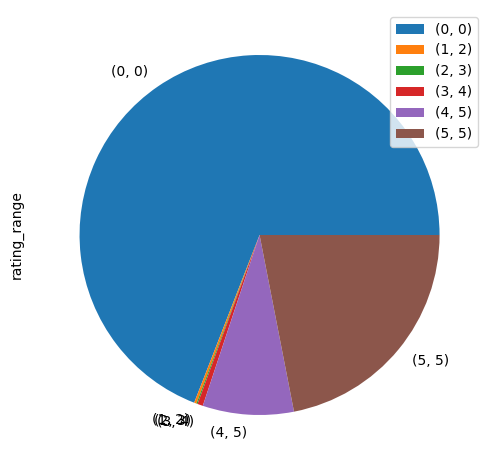

In [79]:
rcp_df.rating_range.value_counts().sort_index().plot.pie()
plt.legend()
plt.show()